In [1]:
import csv
import pandas as pd
import numpy as np
import pprint

Ce module consiste a décrire diachroniquement les voyages arrivant à Marseille

### 1. Filtrage des flows

- Données de "flows" Navigo corpus
- Uniquement la "Santé"

In [2]:
flows_to_Marseille = []
rank_Marseille = {}
with open('../../data/navigo_all_flows.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['destination_function'] == "O" \
        and row["source_suite"] == "la Santé registre de patentes de Marseille":
           # and row['toponyme_fr'] == 'Marseille' \
            flows_to_Marseille.append(row)
            rank_Marseille[row["source_doc_id"]] = row["travel_rank"]


- Prendre note des flows d'arrivées à Marseille
- Isoler les flows qui précèdent les arrivées à Marseille

In [3]:
ranks_smaller_than_Marseille = []
counter_uhgs_99999 = 0
with open('../../data/navigo_all_flows.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row["source_suite"] == "la Santé registre de patentes de Marseille":
            if row["destination_uhgs_id"] == 'A9999997':
                counter_uhgs_99999 += 1
                continue
            if row["source_doc_id"] in rank_Marseille:
                max_rank = rank_Marseille[row["source_doc_id"]]
                if row["travel_rank"] <= max_rank:
                    ranks_smaller_than_Marseille.append(row)
counter_uhgs_99999

1202

### 2. Reconstitution des voyages

- Reconstituer des voyages complets à partir des flows séquentiels
- Attribution de caractéristiques aux voyages :
    - distance parcourue
    - nombre d'étapes
    - date de départ
    - date d'arrivée
    - pavillon
    - classe de bateau

In [4]:
from collections import defaultdict
travels = defaultdict(lambda: {"total_miles": 0, "total_steps": 0, "keep": True})
null_distance = 0

for row in ranks_smaller_than_Marseille:
    doc_id = row["source_doc_id"]
    travel = travels[doc_id]
    distance = row["distance_dep_dest_miles"]
    if distance and distance != '0' and travel["keep"] and row["departure_out_date"]:
        travel["total_miles"] += int(distance)
        travel["total_steps"] += 1
        if row["travel_rank"] == "1":
            travel["departure_date"] = row["departure_out_date"]
        if row["travel_rank"] == rank_Marseille[doc_id]:
            travel["arrival_date"] = row["indate_fixed"] 
            travel["pavillon"] = row["ship_flag_standardized_fr"]
            travel["classe_bateau"] = row["ship_class_standardized"]
            year = row["indate_fixed"][:4]
            travel["year"] = year if year[-1] == "9" else year[:3]+"9"
    else:
        travel["keep"] = False

In [5]:
for travel in travels.values():
    if "year" in travel and travel["year"] == '' and travel["keep"] == True:
        print(travel)

### 3. Suppression des voyages invalides

- Suppression des voyages dont la date est invalide : contient une imprécision sous forme de '<' ou '>'

In [6]:
from datetime import datetime

good_travels = {}
error_list = []

for k, v in travels.items():
    if v["keep"] and ('<' not in v['departure_date'] and '>' not in v['departure_date']):
        travel = v.copy()
        end_time = datetime.strptime(v["arrival_date"], "%Y-%m-%d")
        try:
            start_time = datetime.strptime(v["departure_date"][:10], "%Y=%m=%d")
        except ValueError as e:
            error_list.append(e)
            continue
        travel["duration"] = (end_time - start_time).days
        if travel["duration"] == 0:
            travel["duration"] = 1
        travel["speed"] = v["total_miles"] / travel["duration"]
        travel["decade"] = v["arrival_date"][:4]
        travel.pop("keep")
        good_travels[k] = travel


- Création du dataframe de voyages

In [7]:
df_travels = pd.DataFrame(good_travels).transpose()
df_travels = df_travels[df_travels.duration > 0]

In [8]:
df_travels

,total_miles,total_steps,departure_date,arrival_date,pavillon,classe_bateau,year,duration,speed,decade
00182343,172,1,1786=12=28,1787-01-01,savoyard,Bateau,1789,4,43.0,1787
00182477,451,3,1786=12=20,1787-01-03,français,Brigantin,1789,14,32.214286,1787
00182565,173,1,1787=01=07,1787-01-10,génois,Bateau,1789,3,57.666667,1787
00182793,173,1,1787=01=12,1787-01-24,génois,Bateau,1789,12,14.416667,1787
00182879,173,1,1787=01=24,1787-01-30,génois,Bateau,1789,6,28.833333,1787
...,...,...,...,...,...,...,...,...,...,...
00184681,21,1,1787=04=07,1787-04-07,français,Tartane,1789,1,21.0,1787
00307279,75,1,1759=07=17,1759-07-17,français,Tartane,1759,1,75.0,1759
00314257,75,1,1769=12=15,1769-12-15,français,Tartane,1769,1,75.0,1769
00316572,75,1,1799=03=27,1799-03-27,français,Aviso,1799,1,75.0,1799


### 4. Création des matrices de résultats

- Série d'extractions de données depuis le dataframe des voyages afin de produire des visualisation*

In [9]:
# Vitesse moyenne pour chaque pavillon et chaque décennie
mean_speed = pd.pivot_table(df_travels, values='speed', index=['pavillon'], columns=['year'], aggfunc=np.mean).sort_index()
mean_speed.to_csv("travel_mean_speed_per_flag_and_year.csv")

In [10]:
# Nombre de trajets total pour chaque pavillon et chaque décennie
count = pd.pivot_table(df_travels, values='speed', index=['pavillon'], columns=['year'], aggfunc=np.ma.count).sort_index()
count.to_csv("travel_count_per_flag_and_year.csv")

In [11]:
# Nombre moyen de flows des trajets pour chaque pavillon et chaque décennie
mean_flow_count = pd.pivot_table(df_travels, values='total_steps', index=['pavillon'], columns=['year'], aggfunc=np.mean).sort_index()
mean_flow_count.to_csv("mean_flow_count_per_flag_and_year.csv")

- Isoler le sous ensemble des plus importants pavillons et types de bateau

In [12]:
top_flags = ["suédois", "danois", "britannique","hollandais", "napolitain", "savoyard", "espagnol", "génois", "français"]
top_ships = ["Felouque", "Vaisseau", "Brigantin", "Allège", "Pinque", "Bateau", "Tartane"]


top_ships = df_travels[(df_travels["pavillon"].isin(top_flags))\
                    &(df_travels["classe_bateau"].isin(top_ships))]

top_ships

,total_miles,total_steps,departure_date,arrival_date,pavillon,classe_bateau,year,duration,speed,decade
00182343,172,1,1786=12=28,1787-01-01,savoyard,Bateau,1789,4,43.0,1787
00182477,451,3,1786=12=20,1787-01-03,français,Brigantin,1789,14,32.214286,1787
00182565,173,1,1787=01=07,1787-01-10,génois,Bateau,1789,3,57.666667,1787
00182793,173,1,1787=01=12,1787-01-24,génois,Bateau,1789,12,14.416667,1787
00182879,173,1,1787=01=24,1787-01-30,génois,Bateau,1789,6,28.833333,1787
...,...,...,...,...,...,...,...,...,...,...
00320066,75,1,1749=10=12,1749-10-13,français,Tartane,1749,1,75.0,1749
00184681,21,1,1787=04=07,1787-04-07,français,Tartane,1789,1,21.0,1787
00307279,75,1,1759=07=17,1759-07-17,français,Tartane,1759,1,75.0,1759
00314257,75,1,1769=12=15,1769-12-15,français,Tartane,1769,1,75.0,1769


##### Groupbys

- Par décennie / par pavillon
- Par décennie / par type de bateau / par pavillon
- Par pavillon / par type de bateau

In [13]:
viz_df = df_travels.groupby(['year', 'pavillon']).agg({'speed': 'mean',
                                                       'total_steps': 'mean',
                                                       'total_miles': 'mean',
                                                       'departure_date': 'size',
                                                       'duration': 'mean'
                                                       }
                                                      ).reset_index()
viz_top_ships = top_ships.groupby(['year', 'classe_bateau', "pavillon"]).agg({'speed': 'mean',
                                                       'total_steps': 'mean',
                                                       'total_miles': 'mean',
                                                       'departure_date': 'size',
                                                       'duration': 'mean'
                                                       }
                                                      ).reset_index()

viz_travel_ship = df_travels.groupby(['pavillon', 'classe_bateau']).agg({'speed': 'mean',
                                                       'total_steps': 'mean',
                                                       'total_miles': 'mean',
                                                       'departure_date': 'size',
                                                       'duration': 'mean'
                                                       }
                                                      ).reset_index()

viz_df.columns = ['year', 'pavillon', 'mean_speed', 'mean_number_steps', 'mean_total_miles', 'count_travel', 'mean_duration']

viz_top_ships.columns = ['year', 'classe_bateau', 'pavillon', 'mean_speed', 'mean_number_steps', 'mean_total_miles', 'count_travel', 'mean_duration']

viz_travel_ship.columns = ['pavillon', 'classe_bateau', 'mean_speed', 'mean_number_steps', 'mean_total_miles', 'count_travel', 'mean_duration']


In [14]:
# Nombre trajet par pavillon et par types de bateau (toutes années confondues)
travel_shipclass = pd.pivot_table(df_travels, values='total_miles', index=['pavillon'], columns=['classe_bateau'], aggfunc=np.ma.count, margins=True)\
.transpose().sort_values('All', ascending=False).fillna(0.0)
travel_shipclass.to_csv("travels_count_per_shipclass_perflag.csv")

In [15]:
viz_travel_ship

,pavillon,classe_bateau,mean_speed,mean_number_steps,mean_total_miles,count_travel,mean_duration
0,,Allège,46.000000,1.000000,46.000000,1,1.000000
1,,Aviso,34.791667,1.000000,43.875000,8,2.125000
2,,Barque,27.301733,1.500000,896.500000,2,48.500000
3,,Bateau,35.248810,1.125000,171.875000,8,6.500000
4,,Bombarde,37.604167,1.000000,432.666667,3,22.000000
...,...,...,...,...,...,...,...
193,vénitien,Corvette,23.777778,2.000000,1070.000000,1,45.000000
194,vénitien,Polacre,22.068234,1.666667,549.333333,3,25.000000
195,vénitien,Queche,26.740049,1.666667,938.111111,9,43.000000
196,vénitien,Senau,33.874236,1.300000,751.800000,10,30.900000


### 5. Création des visualisations

- Passage de dataframe Pandas à des listes "VegaLite-ready"
- Configuration de Vegalite

In [16]:
list_viz = []

for i,row in viz_df.iterrows():
    list_viz.append(dict(row))


In [17]:
list_viz_top_ship = []

for i,row in viz_top_ships.iterrows():
    list_viz_top_ship.append(dict(row))

In [18]:
list_viz_travel_ship = []

for i,row in viz_travel_ship.iterrows():
    list_viz_travel_ship.append(dict(row))

In [19]:
from IPython.display import display

def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    display(bundle, raw=True)

#### Vitesse moyenne par pavillon par décennie - Heatmap

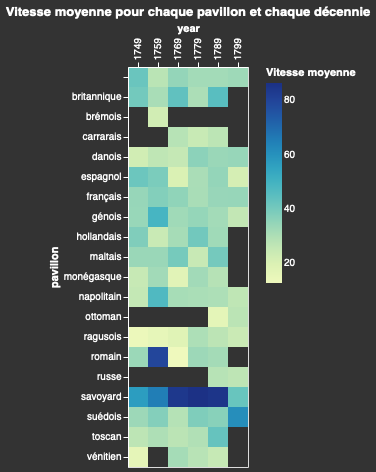

In [20]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Vitesse moyenne pour chaque pavillon et chaque décennie",
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "rect"
    },
    "data": {
        "values": list_viz
    },
    "encoding": {
        "x": {
            "field": "year",
            "type": "nominal", 
            "title": "year",
            "axis": {
                "orient": "top"
            }
        },
        "y": {
            "field": "pavillon",
            "type": "nominal",
            "title": "pavillon"
        },
        "color": {
            "field": "mean_speed",
            "type": "quantitative",
            "title": "Vitesse moyenne"
        }
    }
})

#### Vitesse moyenne par pavillon par décennie - Line chart

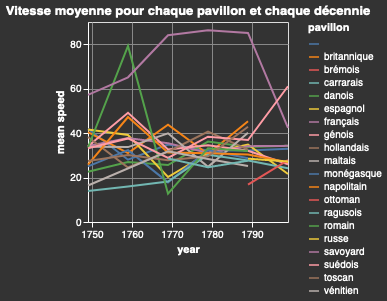

In [21]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Vitesse moyenne pour chaque pavillon et chaque décennie",
    "mark":  "line",
    "data": {
        "values": list_viz
    },
    "encoding": {
        "x": {
            "field": "year",
            "type": "temporal", 
            "title": "year"
        },
        "y": {
            "field": "mean_speed",
            "type": "quantitative",
            "title": "mean speed"
        },
        "color": {
            "field": "pavillon",
            "type": "nominal",
            "title": "pavillon"
        }
    }
})

#### Nombre de trajets total par pavillon par décennie - Heatmap

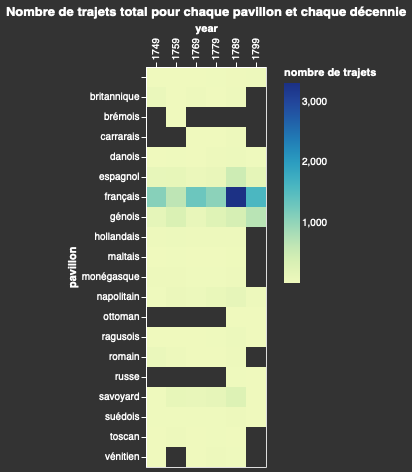

In [22]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Nombre de trajets total pour chaque pavillon et chaque décennie",
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "rect"
    },
    "data": {
        "values": list_viz
    },
    "encoding": {
        "x": {
            "field": "year",
            "type": "nominal", 
            "title": "year",
            "axis": {
                "orient": "top"
            }
        },
        "y": {
            "field": "pavillon",
            "type": "nominal",
            "title": "pavillon"
        },
        "color": {
            "field": "count_travel",
            "type": "quantitative",
            "title": "nombre de trajets"
        }
    }
})

#### Nombre moyen d'étapes par pavillon par décennie - Heatmap

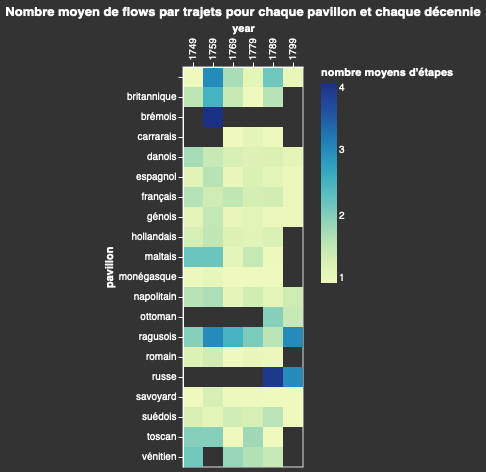

In [23]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Nombre moyen de flows par trajets pour chaque pavillon et chaque décennie",
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "rect"
    },
    "data": {
        "values": list_viz
    },
    "encoding": {
        "x": {
            "field": "year",
            "type": "nominal", 
            "title": "year",
            "axis": {
                "orient": "top"
            }
        },
        "y": {
            "field": "pavillon",
            "type": "nominal",
            "title": "pavillon"
        },
        "color": {
            "field": "mean_number_steps",
            "type": "quantitative",
            "title": "nombre moyens d'étapes"
        }
    }
})

#### Nombre moyen de miles par pavillon par décennie - Heatmap

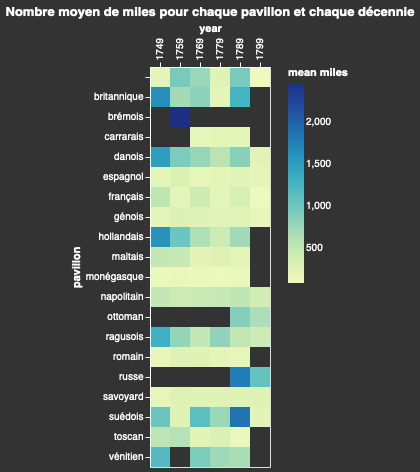

In [24]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Nombre moyen de miles pour chaque pavillon et chaque décennie",
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "rect"
    },
    "data": {
        "values": list_viz
    },
    "encoding": {
        "x": {
            "field": "year",
            "type": "nominal", 
            "title": "year",
            "axis": {
                "orient": "top"
            }
        },
        "y": {
            "field": "pavillon",
            "type": "nominal",
            "title": "pavillon"
        },
        "color": {
            "field": "mean_total_miles",
            "type": "quantitative",
            "title": "mean miles"
        }
    }
})

#### Moyenne des temps de trajets par pavillon par décennie - Heatmap

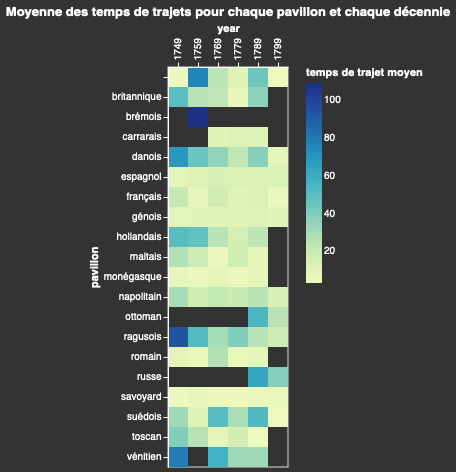

In [25]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Moyenne des temps de trajets pour chaque pavillon et chaque décennie",
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "rect"
    },
    "data": {
        "values": list_viz
    },
    "encoding": {
        "x": {
            "field": "year",
            "type": "nominal", 
            "title": "year",
            "axis": {
                "orient": "top"
            }
        },
        "y": {
            "field": "pavillon",
            "type": "nominal",
            "title": "pavillon"
        },
        "color": {
            "field": "mean_duration",
            "type": "quantitative",
            "title": "temps de trajet moyen"
        }
    }
})

#### Nombre de voyage par pavillon par types de bateau - Heatmap 

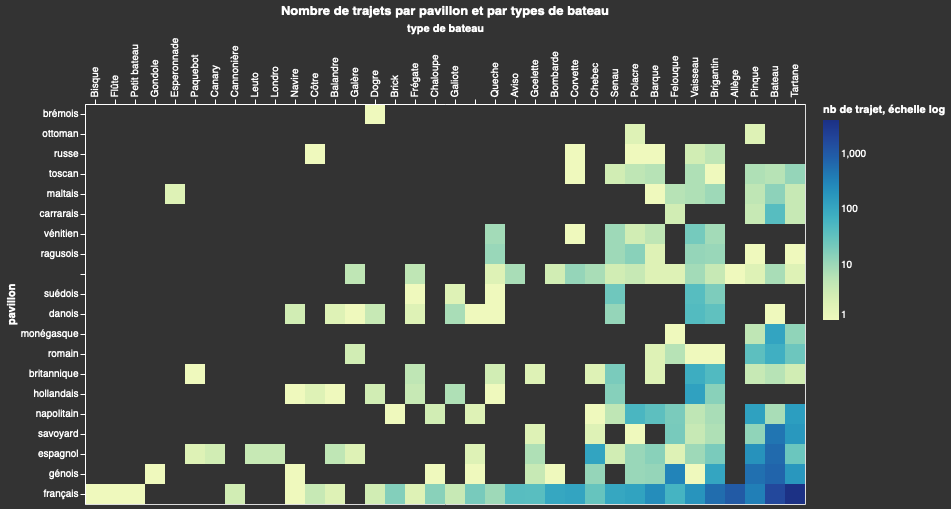

In [26]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Nombre de trajets par pavillon et par types de bateau",
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "rect"
    },
    "data": {
        "values": list_viz_travel_ship
    },
    "encoding": {
        "x": {
            "field": "classe_bateau",
            "type": "nominal", 
            "title": "type de bateau",
            "axis": {
                "orient": "top"
            },
            "sort": {"field": "count_travel", "op": "sum"}
        },
        "y": {
            "field": "pavillon",
            "type": "nominal",
            "title": "pavillon",
            "sort": {"field": "count_travel", "op": "sum"}
        },
        "color": {
            "field": "count_travel",
            "type": "quantitative",
            "title": "nb de trajet, échelle log",
            "scale": {"type": "log"}
        }
    }
})

#### Durée moyenne d'un trajet par pavillon par types de bateau - Heatmap 

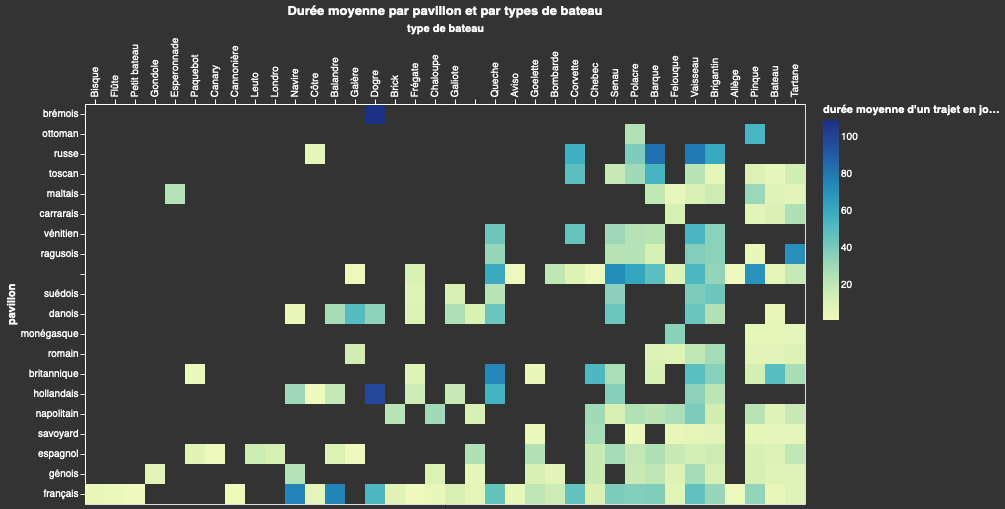

In [27]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Durée moyenne par pavillon et par types de bateau",
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "rect"
    },
    "data": {
        "values": list_viz_travel_ship
    },
    "encoding": {
        "x": {
            "field": "classe_bateau",
            "type": "nominal", 
            "title": "type de bateau",
            "sort": {"field": "count_travel", "op": "sum"},
            "axis": {
                "orient": "top"
            }
        },
        "y": {
            "field": "pavillon",
            "type": "nominal",
            "title": "pavillon",
            "sort": {"field": "count_travel", "op": "sum"}
        },
        "color": {
            "field": "mean_duration",
            "type": "quantitative",
            "title": "durée moyenne d'un trajet en jours"
        }
    }
})

#### Évolution du nombre de trajets par type de bateau - Stacked bar chart

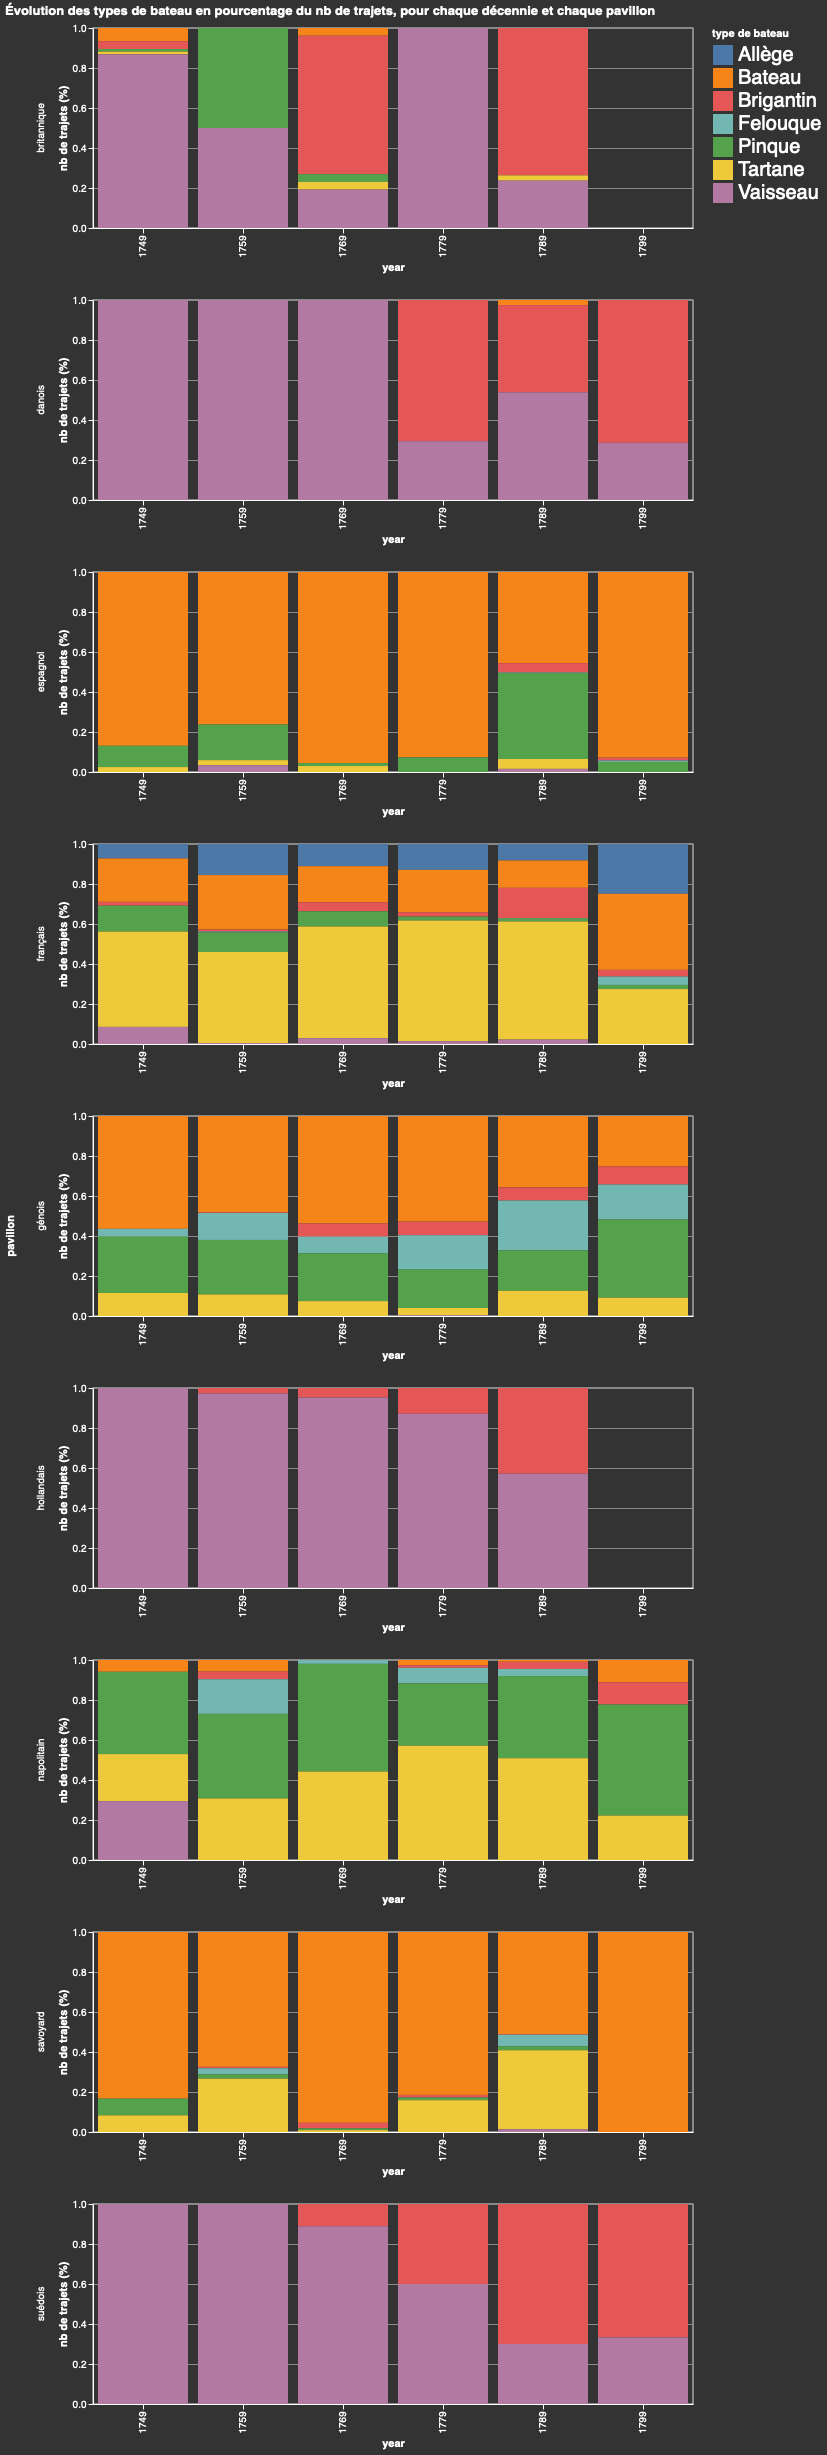

In [28]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Évolution des types de bateau en pourcentage du nb de trajets, pour chaque décennie et chaque pavillon",
    "width": 600,
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "bar",
    },
    "data": {
        "values": list_viz_top_ship
    },
    "encoding": {
        "row": {"field": "pavillon"},
        "x": {
            "field": "year",
            "type": "nominal", 
            "title": "year"
        },
        "y": {
            "field": "count_travel",
            "type": "quantitative",
            "aggregate": "sum",
            "title": "nb de trajets (%)",
            "stack":  "normalize"
        },
        "color": {
            "field": "classe_bateau",
            "title": "type de bateau",
            "legend": {"symbolSize": 400, "labelFontSize": 20,}
        }
            
    },
    "resolve": {"axis": {"x": "independent", "y": "independent"}}
})